<a href="https://colab.research.google.com/github/MohammedHamood/IMDBReviews/blob/main/IMDBReviews_AB_SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IMDB Reviews - AdaBoost with Support Vector Machines

## Data Pre-Processing

In [ ]:
import pandas as pd
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
import preprocessingNLP as PNLP
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_20newsgroups
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA, NMF, TruncatedSVD
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.datasets import load_files
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import Normalizer

# Import Dataset
print("Downloading Dataset ...")
!wget -nv "http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
!tar -xf aclImdb_v1.tar.gz
IMDB_train = load_files('aclImdb/train/', categories=("pos", "neg"), encoding='utf-8')
IMDB_test = load_files('aclImdb/test/', categories=('pos', 'neg'), encoding='utf-8')
print("Dataset Downloaded")

# Preprocessing
print("PREPROCESSING ...")
IMDB_train.data = PNLP.customNLP(IMDB_train.data)
IMDB_test.data = PNLP.customNLP(IMDB_test.data)
IMDB_train.data, IMDB_train.target = PNLP.removeEmptyInstances(IMDB_train.data, IMDB_train.target)
print("PREPROCESSING DONE!")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
2020-03-12 19:22:55 URL:http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz [84125825/84125825] -> "aclImdb_v1.tar.gz" [1]
Dataset Downloaded
PREPROCESSING ...
PREPROCESSING DONE!


## Setting Hyper-Parameters

In the following section, RandomSearchCV is used to evaluate the validation set accuracy of AdaBoost based on random combinations of hyper-parameters used in the validation pipeline. The relevant parameters needed are ngram_range for CountVectorizer and use_idf for TfidfTransformer. AdaBoostClassifier is used with its default attributes except for base_estimator, where LinearSVC is applied with its optimal parameters.

In [ ]:
# Define parameters
parameters = {
     'vect__ngram_range': ((1, 1), (1, 2), (1, 3)),
     'tfidf__use_idf': (True, False),
}

# Create a pipeline
pip = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('Norm', Normalizer(copy=False)),
                ('clf', AdaBoostClassifier(base_estimator=LinearSVC(
                    penalty='l2', dual=True, tol=0.1, C=100), algorithm='SAMME'))])

# Initialize RandomizedSearchCV
n_iter_search = 6
cv_folds = 3
Ada_SVM_rand_search = RandomizedSearchCV(pip, param_distributions=parameters, 
                               n_iter=n_iter_search, cv=cv_folds)

# Utility function to report best scores
def report(results, n_top=10):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})"
                  .format(results['mean_test_score'][candidate],
                          results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("Mean Fit Time: %.3f seconds" %results['mean_fit_time'][candidate])
            print("")

# Execute RandomizedSearchCV and print best results
Ada_SVM_rand_search.fit(IMDB_train.data, IMDB_train.target)
report(Ada_SVM_rand_search.cv_results_)

Model with rank: 1
Mean validation score: 0.875 (std: 0.002)
Parameters: {'vect__ngram_range': (1, 2), 'tfidf__use_idf': True}
Mean Fit Time: 23.671 seconds

Model with rank: 2
Mean validation score: 0.873 (std: 0.004)
Parameters: {'vect__ngram_range': (1, 3), 'tfidf__use_idf': True}
Mean Fit Time: 44.301 seconds

Model with rank: 3
Mean validation score: 0.867 (std: 0.003)
Parameters: {'vect__ngram_range': (1, 3), 'tfidf__use_idf': False}
Mean Fit Time: 43.193 seconds

Model with rank: 4
Mean validation score: 0.867 (std: 0.003)
Parameters: {'vect__ngram_range': (1, 2), 'tfidf__use_idf': False}
Mean Fit Time: 21.996 seconds

Model with rank: 5
Mean validation score: 0.860 (std: 0.001)
Parameters: {'vect__ngram_range': (1, 1), 'tfidf__use_idf': True}
Mean Fit Time: 5.736 seconds

Model with rank: 6
Mean validation score: 0.857 (std: 0.002)
Parameters: {'vect__ngram_range': (1, 1), 'tfidf__use_idf': False}
Mean Fit Time: 5.810 seconds



These results show a brief idea of the required parameters for CountVectorizer and TfidfTransformer.
Setting *use_idf=True* for TfidfTransformer clearly seems to increase the mean validation set accuracy. This confirms that downscaling weights for words that occur in many documents improves the probability of obtaining the best accuracy. Additionally, it is a good idea to evaluate a larger size of word n-grams for the model. *ngram_range=(1, 2)* will be used for CountVectorizer. 

Now, GridSearchCV is used to evaluate the hyper-parameters that could potentially optimize the validation accuracy of AdaBoostClassifier with the optimized attributes for SVM. Only the relevant parameters of the model are evaluated by combining different values for *n_estimators* and *learning_rate*.

In [ ]:
# Set relevant parameters
parameters = {
    'n_estimators': (100, 200, 400),
    'learning_rate': (0.01, 0.1, 1)
}

# Create a pipeline
pip = Pipeline([('vect', CountVectorizer(ngram_range=(1, 2))),
                ('tfidf', TfidfTransformer(use_idf=True)),
                ('Norm', Normalizer(copy=False)),
                ('clf', GridSearchCV(AdaBoostClassifier(base_estimator=LinearSVC(
                    penalty='l2', dual=True, tol=0.1, C=100), algorithm='SAMME'),
                                     parameters, cv=3, n_jobs=-1))])

# Execute pipeline
pip.fit(IMDB_train.data, IMDB_train.target)

# Collect and print results
test_accuracies = pip['clf'].cv_results_['mean_test_score']
test_time = pip['clf'].cv_results_['mean_fit_time']
test_params = pip['clf'].cv_results_['params']

for i in range(len(test_time)):
  print("Parameter: {0}".format(test_params[i]))
  print("Training Time: %.3f seconds" %test_time[i])
  print("Valdation Accuracy: {0:.3f}".format(test_accuracies[i]))
  print("")

print("Validation Accuracy: " + str(pip['clf'].best_score_))
print("Optimal Parameters: " + str(pip['clf'].best_params_))

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Parameter: {'learning_rate': 0.01, 'n_estimators': 100}
Training Time: 41.971 seconds
Valdation Accuracy: 0.872

Parameter: {'learning_rate': 0.01, 'n_estimators': 200}
Training Time: 41.047 seconds
Valdation Accuracy: 0.874

Parameter: {'learning_rate': 0.01, 'n_estimators': 400}
Training Time: 40.821 seconds
Valdation Accuracy: 0.874

Parameter: {'learning_rate': 0.1, 'n_estimators': 100}
Training Time: 5.547 seconds
Valdation Accuracy: 0.877

Parameter: {'learning_rate': 0.1, 'n_estimators': 200}
Training Time: 5.344 seconds
Valdation Accuracy: 0.876

Parameter: {'learning_rate': 0.1, 'n_estimators': 400}
Training Time: 6.186 seconds
Valdation Accuracy: 0.877

Parameter: {'learning_rate': 1, 'n_estimators': 100}
Training Time: 43.354 seconds
Valdation Accuracy: 0.880

Parameter: {'learning_rate': 1, 'n_estimators': 200}
Training Time: 88.087 seconds
Valdation Accuracy: 0.886

Parameter: {'learning_rate': 1, 'n_estimators': 400}
Training Time: 159.606 seconds
Valdation Accuracy: 0.88

The previous results show that a learning rate of 1 is a good value for optimizing the accuracy. However, more information is needed regarding the number of estimator. It seems that increasing it more than 400 could probably improve the accuracy.

The next section analyzes how the number of estimator has an impact on the validation set accuracy of this model.

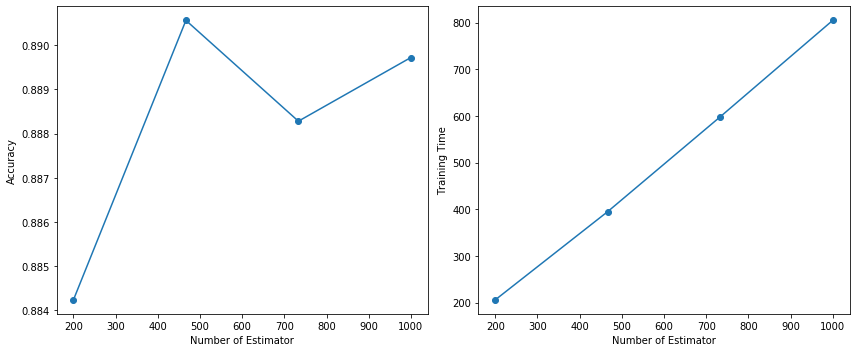

In [ ]:
# Create list of number of estimators
nbr_estimator = np.linspace(200, 1000 , 4)
accuracies = []
runtimes = []

# Evaluate validation set accuracy for each C
for nbr in nbr_estimator:

  # Create a pipeline
  pip = Pipeline([('vect', CountVectorizer(ngram_range=(1, 2))),
                ('tfidf', TfidfTransformer(use_idf=True)),
                ('Norm', Normalizer(copy=False)),
                ('clf', AdaBoostClassifier(base_estimator=LinearSVC(
                    penalty='l2', dual=True, tol=0.1, C=100), algorithm='SAMME', learning_rate=1, n_estimators=int(nbr)))])

  # Evaluate validation set accuracy
  start = time.perf_counter()
  scores = cross_val_score(pip, IMDB_train.data, IMDB_train.target, cv=3)
  elapsed_time = time.perf_counter()-start
  accuracies.append(np.mean(scores))
  runtimes.append(elapsed_time)

#Display Results
fig = plt.figure(figsize=(12,5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.plot(nbr_estimator, accuracies, 'o-')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Number of Estimator')
ax2.plot(nbr_estimator, runtimes, 'o-')
ax2.set_ylabel('Training Time')
ax2.set_xlabel('Number of Estimator')
plt.tight_layout()
plt.show()

In [ ]:
print(nbr_estimator)

[ 200.          466.66666667  733.33333333 1000.        ]


Based the previous graphs, the accuracy seems to peak around 466 estimators. Another test should be made around this value to get an optimal accuracy.

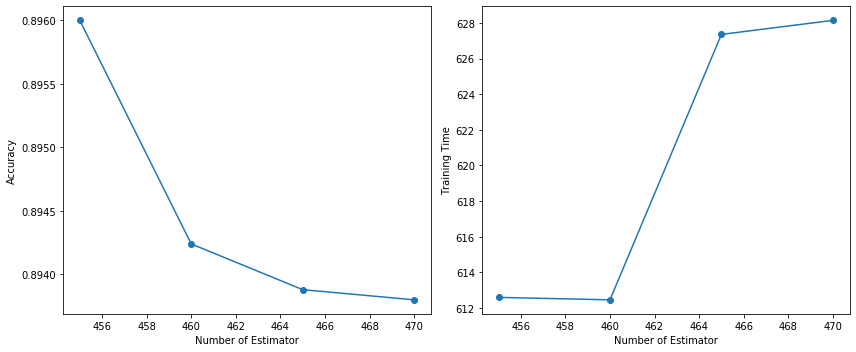

In [ ]:
# Create list of number of estimators
nbr_estimator = [455, 460, 465, 470]
accuracies = []
runtimes = []

# Evaluate validation set accuracy for each C
for nbr in nbr_estimator:

  # Create a pipeline
  pip = Pipeline([('vect', CountVectorizer(ngram_range=(1, 2))),
                ('tfidf', TfidfTransformer(use_idf=True)),
                ('Norm', Normalizer(copy=False)),
                ('clf', AdaBoostClassifier(base_estimator=LinearSVC(
                    penalty='l2', dual=True, tol=0.1, C=100), algorithm='SAMME', learning_rate=1, n_estimators=int(nbr)))])

  # Evaluate validation set accuracy
  start = time.perf_counter()
  scores = cross_val_score(pip, IMDB_train.data, IMDB_train.target, cv=3)
  elapsed_time = time.perf_counter()-start
  accuracies.append(np.mean(scores))
  runtimes.append(elapsed_time)

#Display Results
fig = plt.figure(figsize=(12,5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.plot(nbr_estimator, accuracies, 'o-')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Number of Estimator')
ax2.plot(nbr_estimator, runtimes, 'o-')
ax2.set_ylabel('Training Time')
ax2.set_xlabel('Number of Estimator')
plt.tight_layout()
plt.show()

Looking at the previous results, it seems that *n_estimator=455* is a good value for this parameter.

# Final Result

In [ ]:
# Create a pipeline
pip = Pipeline([('vect', CountVectorizer(ngram_range=(1, 2))),
                ('tfidf', TfidfTransformer(use_idf=True)),
                ('Norm', Normalizer(copy=False)),
                ('clf', AdaBoostClassifier(base_estimator=LinearSVC(
                    penalty='l2', dual=True, tol=0.1, C=100), algorithm='SAMME', learning_rate=1, n_estimators=455))])

# Evaluate validation set accuracy
start_time = time.time()
scores = cross_val_score(pip, IMDB_train.data, IMDB_train.target, cv=10)
valid_accuracy = np.mean(scores)
print("10-Cross Validation Runtime: %s seconds" % (time.time() - start_time))
print("Validation Set Accuracy: {0}".format(valid_accuracy))

# Fit the model
start_time = time.time()
pip.fit(IMDB_train.data, IMDB_train.target)
print("Training Runtime: %s seconds" % (time.time() - start_time))

# Get prediction on test set
start_time = time.time()
IMDB_pred = pip.predict(IMDB_test.data)
print("Prediction Runtime: %s seconds" % (time.time() - start_time))

# Compute test set accuracy
test_accuracy = np.mean(IMDB_pred==IMDB_test.target)
print("Test Set Accuracy: {0}".format(test_accuracy))

10-Cross Validation Runtime: 2664.3755552768707 seconds
Validation Set Accuracy: 0.90008
Training Runtime: 288.596951007843 seconds
Prediction Runtime: 36.48050904273987 seconds
Test Set Accuracy: 0.89584
